### Bolinger Band and RSI strategy

In [103]:
import time
from datetime import datetime

import pandas as pd
import pandas_ta as ta
import numpy as np
import mplfinance as mpf
from scipy.signal import argrelextrema
from collections import deque

### import csv

In [131]:
data = pd.read_csv('USDJPY_15m_2022_01_03.csv')
data.tail()

,timestamp,open,high,low,close,adj close,volumn
3887,2021-12-31 20:45:00+00:00,115.051003,115.110001,115.010002,115.095001,115.095001,0
3888,2021-12-31 21:00:00+00:00,115.091003,115.095001,115.029999,115.056999,115.056999,0
3889,2021-12-31 21:15:00+00:00,115.056999,115.073997,115.019997,115.061996,115.061996,0
3890,2021-12-31 21:30:00+00:00,115.061996,115.087997,115.040001,115.070000,115.070000,0
3891,2021-12-31 21:45:00+00:00,115.080002,115.116997,115.050003,115.102997,115.102997,0


In [141]:
df = data.copy()

### Scan Doji candle

In [168]:
def scan_doji(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace = True)
    df.loc[ (df.iloc[:, -6].round(4) == df.iloc[:, -3].round(4)) , 'doji'] = 1    
    
    df['doji'].fillna(0)     
    df.loc[df.iloc[:, -1] == 1]
    return df

In [178]:
df_test = data.copy()[2950:3000]
df_test = scan_doji(df_test)

marks = ['^' if x == 1 else '' for x in df_test['doji']]
color = ['b' if x == 1 else 'g' for x in df_test['doji']]
cdl_plot = mpf.make_addplot(df_test['low'],type='scatter',marker=marks,color=color,markersize=100)
df_test.loc[df_test.iloc[:, -1] == 1]
# df_test.shape[0]

,open,high,low,close,adj close,volumn,doji
timestamp,,,,,,,
2021-12-20 02:45:00+00:00,113.587997,113.593002,113.489998,113.587997,113.587997,0,1.0
2021-12-20 04:15:00+00:00,113.511002,113.537003,113.470001,113.511002,113.511002,0,1.0
2021-12-20 05:30:00+00:00,113.455002,113.480003,113.410004,113.455002,113.455002,0,1.0


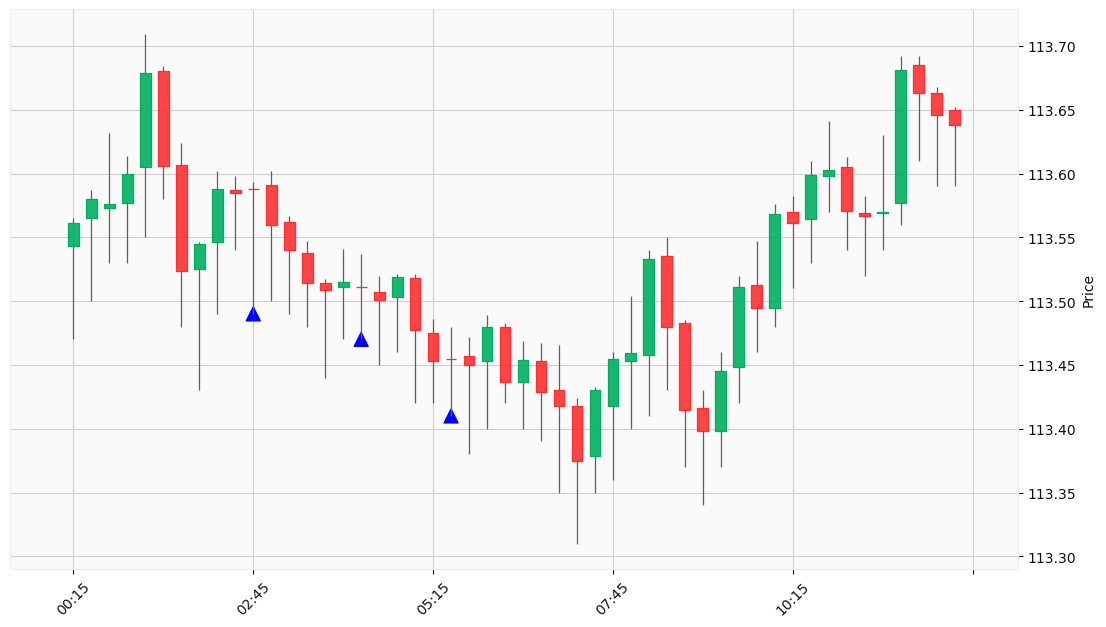

In [179]:
mpf.plot(df_test,addplot=cdl_plot ,type='candle',style='yahoo',figsize=(14,8))

### Create strategy

In [72]:
bollinger_rsi = ta.Strategy(
    name = 'Bollinger Band and RSI',
    description = 'Bollinger Band and RSI strategy',
    ta = [
        {'kind': 'bbands', 'length': 30},
        {'kind': 'rsi', 'length': 14},
        {'kind': 'atr', 'length': 14}
    ]
)
df.ta.strategy(bollinger_rsi)
# BBU -> upper band, BBM -> middle band, BBL -> lower band
df

,timestamp,open,high,low,close,adj close,volumn,BBL_30_2.0,BBM_30_2.0,BBU_30_2.0,BBB_30_2.0,BBP_30_2.0,RSI_14,ATRr_14
0,2021-11-04 17:00:00+00:00,113.750000,113.750999,113.690002,113.724998,113.724998,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-11-04 17:15:00+00:00,113.726997,113.731003,113.629997,113.686996,113.686996,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-11-04 17:30:00+00:00,113.683998,113.720001,113.650002,113.717003,113.717003,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-11-04 17:45:00+00:00,113.720001,113.720001,113.620003,113.680000,113.680000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-11-04 18:00:00+00:00,113.680000,113.703003,113.639999,113.681999,113.681999,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3887,2021-12-31 20:45:00+00:00,115.051003,115.110001,115.010002,115.095001,115.095001,0,115.022432,115.079334,115.136236,0.098892,0.637670,52.589957,0.071125
3888,2021-12-31 21:00:00+00:00,115.091003,115.095001,115.029999,115.056999,115.056999,0,115.021860,115.077234,115.132607,0.096237,0.317291,47.001392,0.070688
3889,2021-12-31 21:15:00+00:00,115.056999,115.073997,115.019997,115.061996,115.061996,0,115.021194,115.075767,115.130340,0.094847,0.373836,47.787142,0.069496
3890,2021-12-31 21:30:00+00:00,115.061996,115.087997,115.040001,115.070000,115.070000,0,115.020791,115.075333,115.129876,0.094795,0.451105,49.088962,0.067960


### Create signal

In [80]:
class BacktestBollingerBandRSI:
    def __init__(self, params):
        self.orders = pd.DataFrame(columns = ['action', 'open time', 'open', 'close time', 'close', 'T/P', 'S/L', 'result'])
        self.order = {'action': None, 'open time': None, 'open': None, 'close time': None, \
                      'close': None, 'T/P': None, 'S/L': None,'result': None}
        self.unknow_result = []
        
        self.current_action = 'close'
        self.atr = params['atr']
        self.bbands = params['bbands']
        self.rsi = params['rsi']
        
        self.pip_value = params['pip_value']
        self.rr = params['rr']
        self.df = params['df']
        self.plot = params['plot']
        
        self.overbought = params['overbought']
        self.oversold = params['oversold']
        self.bars_status = 'idle' # idle, break_high, break_low, overbought, oversold, bullish_di, bearish_di, entry
        
    def reset_order(self):
        self.order = {'action': None, 'open time': None, 'open': None, 'close time': None, \
                      'close': None, 'T/P': None, 'S/L': None,'result': None}
        
    def plot_order(self, order):
        df = self.df.copy()
        df.set_index('timestamp', inplace = True)
        data_plot = df.loc[order['open time']:order['close time']]
        
        entry_line = np.empty(data_plot.shape[0])
        entry_line.fill(order['open'])

        tp_line = np.empty(data_plot.shape[0])
        tp_line.fill(order['T/P'])

        sl_line = np.empty(data_plot.shape[0])
        sl_line.fill(order['S/L'])

        bbu_line = data_plot['BBU_'+str(self.bbands)+'_2.0']
        bbm_line = data_plot['BBM_'+str(self.bbands)+'_2.0']
        bbl_line = data_plot['BBL_'+str(self.bbands)+'_2.0']
        
        bbu_plot = mpf.make_addplot(bbu_line, panel=0, color='blue', width=1.5)
        bbm_plot = mpf.make_addplot(bbm_line, panel=0, color='hotpink', width=1.5)
        bbl_plot = mpf.make_addplot(bbl_line, panel=0, color='gray', width=1.5)

        entry_plot = mpf.make_addplot(entry_line, panel=0, color='blue', width=1.5)
        tp_plot = mpf.make_addplot(tp_line, panel=0, color='green', linestyle = 'dashed', width=1)
        sl_plot = mpf.make_addplot(sl_line, panel=0, color='red', linestyle = 'dotted', width=2)
        
        mpf.plot(data_plot, 
                 type='candle', 
                 style='charles', 
                 addplot=[bbu_plot, bbm_plot, bbl_plot, entry_plot, tp_plot, sl_plot], 
                 figsize=(8, 4))
    
    def check_breakout(self, row):
        if row['close'] > row['open']:
            
            if (row['BBU_' + str(self.bbands) + '_2.0'] < row['close']) and \
            row['BBU_' + str(self.bbands) + '_2.0'] > row['open'] and \
            row['open'] > row['BBM_' + str(self.bbands) + '_2.0']:
                self.bars_status = 'break_high'
                
            elif (row['BBL_' + str(self.bbands) + '_2.0'] < row['close']) and \
            row['BBL_' + str(self.bbands) + '_2.0'] > row['open'] and \
            row['close'] < row['BBM_' + str(self.bbands) + '_2.0']:
                self.bars_status = 'break_low'
                
        elif row['close'] < row['open']:
            
            if (row['BBU_' + str(self.bbands) + '_2.0'] > row['close']) and \
            row['BBU_' + str(self.bbands) + '_2.0'] < row['open'] and \
            row['close'] > row['BBM_' + str(self.bbands) + '_2.0']:
                self.bars_status = 'break_high'
                
            elif (row['BBL_' + str(self.bbands) + '_2.0'] > row['close']) and \
            row['BBL_' + str(self.bbands) + '_2.0'] < row['open'] and \
            row['open'] < row['BBM_' + str(self.bbands) + '_2.0']:
                self.bars_status = 'break_low'
        
    def check_over_rsi(self, row):
        if self.bars_status == 'break_high':
            if row['RSI_' + str(self.rsi)] > self.overbought:
                self.bars_status = 'overbought'
        elif self.bars_status == 'break_low':
            if row['RSI_' + str(self.rsi)] < self.oversold:
                self.bars_status = 'oversold'
                
    def check_doji(self, row, index):
        pass
        # if is Doji or in condition red or green bar then create entry.
        # else set bars status to idle.
        # return action and set bars status to idle.
                
    def backtest(self):
        n_bars = 3
        bollinger_rsi = ta.Strategy(
            name = 'Bollinger Band and RSI',
            description = 'Bollinger Band and RSI strategy',
            ta = [
                {'kind': 'bbands', 'length': self.bbands},
                {'kind': 'rsi', 'length': self.rsi},
                {'kind': 'atr', 'length': self.atr}
            ]
        )
        self.df.ta.strategy(bollinger_rsi)
        self.df = self.df.dropna()
        self.df['timestamp'] = pd.to_datetime(self.df['timestamp'])
        # do scan doji
        
        for index, row in self.df.iterrows():
            entry = 0
            
            if self.current_action == 'close':
                if self.bars_status == 'idle':
                    self.check_breakout(row)
                    
                if (self.bars_status == 'break_high') or (self.bars_status == 'break_low'):
                    self.check_over_rsi(row)
                    if (self.bars_status == 'overbought') or (self.bars_status == 'oversold'):
                        continue
                    
                if (self.bars_status == 'overbought') or (self.bars_status == 'oversold'):
                    self.check_doji(row, index)
                    
                if (self.bars_status == 'bullish_di') or (self.bars_status == 'bearish_di'):
                    action = self.check_middle_line(row)
                    
                    if action == 'buy':
                        self.bars_status = 'idle'
                        row['action'] = 'buy'
                        self.order['action'] = 'buy'
                        self.order['open time'] = row['timestamp']
                        
                        self.order['open'] = row['close']
                        self.order['S/L'] = row['close'] - row['ATRr_'+str(self.atr)]
                        self.order['T/P'] = row['close'] + (self.rr * abs(row['close'] - self.order['S/L']))
                        self.current_action = 'buy'
                    
                    elif action == 'sell':
                        self.bars_status = 'idle'
                        row['action'] = 'sell'
                        self.order['action'] = 'sell'
                        self.order['open time'] = row['timestamp']
                        
                        self.order['open'] = row['close']
                        self.order['S/L'] = row['close'] + row['ATRr_'+str(self.atr)]
                        self.order['T/P'] = row['close'] - (self.rr * abs(row['close'] - self.order['S/L']))
                        self.current_action = 'sell'
        
            if self.current_action == 'buy':
                if row['low'] <= self.order['S/L'] and row['high'] >= self.order['T/P']:
                    self.unknow_result.append(row)
                    
                if row['low'] <= self.order['S/L']:
                    self.order['result'] = 'S/L'
                    self.order['close time'] = row['timestamp']
                    self.order['close'] = self.order['S/L']
                    
                    self.current_action = 'close'
                    self.orders = self.orders.append(self.order, ignore_index = True)
                    if self.plot == True: self.plot_order(self.order)
                    self.reset_order()
                    
                elif row['high'] >= self.order['T/P']:
                    self.order['result'] = 'T/P'
                    self.order['close time'] = row['timestamp']
                    self.order['close'] = self.order['T/P']
                    
                    self.current_action = 'close'
                    self.orders = self.orders.append(self.order, ignore_index = True)
                    if self.plot == True: self.plot_order(self.order)
                    self.reset_order()

            elif self.current_action == 'sell':
                if row['high'] >= self.order['S/L'] and row['low'] <= self.order['T/P']:
                    self.unknow_result.append(row)
                    
                if row['high'] >= self.order['S/L']:
                    self.order['result'] = 'S/L'
                    self.order['close time'] = row['timestamp']
                    self.order['close'] = self.order['S/L']
                    
                    self.current_action = 'close'
                    self.orders = self.orders.append(self.order, ignore_index = True)
                    if self.plot == True: self.plot_order(self.order)
                    self.reset_order()
                    
                elif row['low'] <= self.order['T/P']:
                    self.order['result'] = 'T/P'
                    self.order['close time'] = row['timestamp']
                    self.order['close'] = self.order['T/P']
                    
                    self.current_action = 'close'
                    self.orders = self.orders.append(self.order, ignore_index = True)
                    if self.plot == True: self.plot_order(self.order)
                    self.reset_order()

        try:
            win_rate = round(len(self.orders[self.orders['result'] == 'T/P']) * 100 / len(self.orders), 2)
            loss_rate = round(len(self.orders[self.orders['result'] == 'S/L']) * 100 / len(self.orders), 2)

            win_orders = int((win_rate * len(self.orders)) / 100 )
            loss_orders = len(self.orders) - win_orders
            gain = (win_orders * self.rr) - loss_orders

            result_info = f"total orders: {len(self.orders)}\nbbands: {self.bbands}, rsi: {self.rsi}, atr: {self.atr}, gain: {gain}\n"
            return {'win_rate': win_rate, 'info': result_info, 'total_order': len(self.orders), 'rr': self.rr, 'gain': gain, 'unknow': self.unknow_result}
        except:
    #         print("No orders to action")
            return {'win_rate': 0, 'info': 'No orders to action'}

In [81]:
pair = BacktestBollingerBandRSI({
    'atr': 14,
    'bbands': 30,
    'rsi': 14,
    'pip_value': 0.001,
    'rr': 2,
    'df': df,
    'overbought': 70,
    'oversold': 30,
    'plot': False
})
pair.backtest()

<ipython-input-75-33a959aef1e6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
C:\Users\A715-72G\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-75-33a959aef1e6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-75-33a959aef1e6>:13: Se

{'win_rate': 13.33,
 'info': 'total orders: 15\nbbands: 30, rsi: 14, atr: 14, gain: -12\n',
 'total_order': 15,
 'rr': 2,
 'gain': -12,
 'unknow': []}

In [63]:
"""
Grid parameter example
bbands: 20 -> 40
rsi: 10 -> 20
overbought: 65 -> 75
oversold: 25 -> 35
"""
def create_grid_params(bbands_start, bbands_end, rsi_start, rsi_end, overb_start, overb_end, overs_start, overs_end):
    params = []
    for i in range(bbands_start, bbands_end+1):
        for j in range(rsi_start, rsi_end+1):
            for k in range(overb_start, overb_end):
                for l in range(overs_start, overs_end):
                    params.append([i, j, k, l])
    return params
params_list = create_grid_params(20, 40, 10, 20, 65, 75, 25, 35)
len(params_list)

23100

In [64]:
good_params = {'win': 0, 'info': ''}
start = 0
end = 10
win_start = 0

loop_num = start
for param in params_list[start:end]:
    obj = BacktestBollingerBandRSI({'bbands': param[0], 'rsi': param[1], 'atr': 14, 'overbought': param[2], 'oversold': param[3], 'pip_value': 0.001, 'rr': 1.5, 'df': df, 'plot': False})
    result = obj.backtest()
    if result['win_rate'] > win_start and result['total_order'] > 30:
        win_start = result['win_rate']
        good_params['win'] = result['win_rate']
        good_params['info'] = result['info']
    loop_num = loop_num + 1
    print(f"run: {loop_num} to {end}", end = "\r")
    
print(f"\nwin rate: {good_params['win']} %\n{good_params['info']}")

C:\Users\A715-72G\anaconda3\lib\site-packages\pandas_ta\core.py:420: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = result.iloc[:, i]
C:\Users\A715-72G\anaconda3\lib\site-packages\pandas_ta\core.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ind_name] = result
C:\Users\A715-72G\anaconda3\lib\site-packages\pandas_ta\core.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

C:\Users\A715-72G\anaconda3\lib\site-packages\pandas_ta\core.py:420: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = result.iloc[:, i]
C:\Users\A715-72G\anaconda3\lib\site-packages\pandas_ta\core.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ind_name] = result
C:\Users\A715-72G\anaconda3\lib\site-packages\pandas_ta\core.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

C:\Users\A715-72G\anaconda3\lib\site-packages\pandas_ta\core.py:420: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = result.iloc[:, i]
C:\Users\A715-72G\anaconda3\lib\site-packages\pandas_ta\core.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ind_name] = result
C:\Users\A715-72G\anaconda3\lib\site-packages\pandas_ta\core.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

C:\Users\A715-72G\anaconda3\lib\site-packages\pandas_ta\core.py:420: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = result.iloc[:, i]
C:\Users\A715-72G\anaconda3\lib\site-packages\pandas_ta\core.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ind_name] = result
C:\Users\A715-72G\anaconda3\lib\site-packages\pandas_ta\core.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

C:\Users\A715-72G\anaconda3\lib\site-packages\pandas_ta\core.py:420: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = result.iloc[:, i]
C:\Users\A715-72G\anaconda3\lib\site-packages\pandas_ta\core.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ind_name] = result
C:\Users\A715-72G\anaconda3\lib\site-packages\pandas_ta\core.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

C:\Users\A715-72G\anaconda3\lib\site-packages\pandas_ta\core.py:420: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = result.iloc[:, i]
C:\Users\A715-72G\anaconda3\lib\site-packages\pandas_ta\core.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ind_name] = result
C:\Users\A715-72G\anaconda3\lib\site-packages\pandas_ta\core.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

C:\Users\A715-72G\anaconda3\lib\site-packages\pandas_ta\core.py:420: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = result.iloc[:, i]
C:\Users\A715-72G\anaconda3\lib\site-packages\pandas_ta\core.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ind_name] = result
C:\Users\A715-72G\anaconda3\lib\site-packages\pandas_ta\core.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

C:\Users\A715-72G\anaconda3\lib\site-packages\pandas_ta\core.py:420: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = result.iloc[:, i]
C:\Users\A715-72G\anaconda3\lib\site-packages\pandas_ta\core.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ind_name] = result
C:\Users\A715-72G\anaconda3\lib\site-packages\pandas_ta\core.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

C:\Users\A715-72G\anaconda3\lib\site-packages\pandas_ta\core.py:420: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = result.iloc[:, i]
C:\Users\A715-72G\anaconda3\lib\site-packages\pandas_ta\core.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ind_name] = result
C:\Users\A715-72G\anaconda3\lib\site-packages\pandas_ta\core.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

run: 10 to 10
win rate: 0 %



C:\Users\A715-72G\anaconda3\lib\site-packages\pandas_ta\core.py:420: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = result.iloc[:, i]
C:\Users\A715-72G\anaconda3\lib\site-packages\pandas_ta\core.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ind_name] = result
C:\Users\A715-72G\anaconda3\lib\site-packages\pandas_ta\core.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [7]:
a = [i for i in range(10)]
a

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [9]:
index = 7
a[index-4: index+4]

[3, 4, 5, 6, 7, 8, 9]